In [2]:
import os
import findspark
findspark.init('/usr/lib/spark/')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import pyspark
sc = pyspark.SparkContext.getOrCreate()
from pyspark import SQLContext
sql = SQLContext(sc)

In [4]:
#Load all the required Datasets
#Reference: https://gist.github.com/nicor88/7f935d1a7636121f94e83bc68a9c744b for specifying the file path to read the csv file

airlines_data = sql.read.csv('s3://hemuawsbucket/notebooks/airlines/airlines.csv', header = True)
data1 = sql.read.csv('s3://hemuawsbucket/notebooks/2015_flight_data.csv', header = True)
data2 = sql.read.csv('s3://hemuawsbucket/notebooks/2016_flight_data.csv', header = True)
data3 = sql.read.csv('s3://hemuawsbucket/notebooks/2017_flight_data.csv', header = True)

In [5]:
#merge all the data sets in to one dataframe

flights_data = data1.unionAll(data2)
flights_data = flights_data.unionAll(data3)

In [6]:
#Clean data by replacing CANCELLATION_CODE abbrevation

from pyspark.sql.functions import when

flights_data = flights_data.withColumn("CANCELLATION_CODE", when(flights_data["CANCELLATION_CODE"] == 'A', 'Carrier').otherwise(flights_data["CANCELLATION_CODE"]))
flights_data = flights_data.withColumn("CANCELLATION_CODE", when(flights_data["CANCELLATION_CODE"] == 'B', 'Weather').otherwise(flights_data["CANCELLATION_CODE"]))
flights_data = flights_data.withColumn("CANCELLATION_CODE", when(flights_data["CANCELLATION_CODE"] == 'C', 'National Air System').otherwise(flights_data["CANCELLATION_CODE"]))
flights_data = flights_data.withColumn("CANCELLATION_CODE", when(flights_data["CANCELLATION_CODE"] == 'D', 'Security').otherwise(flights_data["CANCELLATION_CODE"]))

In [7]:
#Find the total number of flights

Total_flights = flights_data.groupBy('CARRIER').count()
Total_flights = Total_flights.selectExpr("CARRIER as CARRIER", "count as total_flights")
Total_flights.show()

+-------+-------------+
|CARRIER|total_flights|
+-------+-------------+
|     UA|      1499734|
|     NK|       373314|
|     AA|      2323492|
|     EV|      1340779|
|     B6|       776217|
|     DL|      2507114|
|     OO|      1719476|
|     F9|       260844|
|CARRIER|           30|
|     US|       198715|
|     MQ|       294632|
|     HA|       213815|
|     AS|       491800|
|     VX|       183497|
|     WN|      3563223|
+-------+-------------+



In [8]:
# 1a.Calculate the number of Operated flights for each Airline

import pyspark.sql.functions as func
scheduled_flights = flights_data.groupby(flights_data.CARRIER).agg(func.count('CRS_DEP_TIME'))

In [9]:
cancelled_data = flights_data[flights_data['CANCELLED']==1]
cancelled_flights = cancelled_data.groupby(cancelled_data.CARRIER).count()
cancelled_flights = cancelled_flights.selectExpr("CARRIER as CARRIER", "count as Cancelled_Flights")
cancelled_flights.show()

+-------+-----------------+
|CARRIER|Cancelled_Flights|
+-------+-----------------+
|     UA|            17463|
|     NK|             9364|
|     AA|            34033|
|     EV|            36824|
|     B6|            15747|
|     DL|            16411|
|     OO|            25277|
|     F9|             2064|
|     US|             4067|
|     MQ|            15025|
|     HA|              456|
|     AS|             2424|
|     VX|             1955|
|     WN|            46505|
+-------+-----------------+



In [10]:
operated_flights = scheduled_flights.join(cancelled_flights, scheduled_flights.CARRIER == cancelled_flights.CARRIER).drop(cancelled_flights.CARRIER)
dif = operated_flights['count(CRS_DEP_TIME)'] - operated_flights['Cancelled_Flights']
operated_flights = operated_flights.withColumn('OPERATED_FLIGHTS', dif).select(['CARRIER', 'OPERATED_FLIGHTS'])
operated_flights.show()

+-------+----------------+
|CARRIER|OPERATED_FLIGHTS|
+-------+----------------+
|     UA|         1482271|
|     NK|          363950|
|     AA|         2289459|
|     EV|         1303955|
|     B6|          760470|
|     DL|         2490703|
|     OO|         1694199|
|     F9|          258780|
|     US|          194648|
|     MQ|          279607|
|     HA|          213359|
|     AS|          489376|
|     VX|          181542|
|     WN|         3516718|
+-------+----------------+



In [11]:
# 1b.Calculate the number of cancelled flights caused by each reason for each airline

cancelled_data.groupby(cancelled_data.CARRIER, cancelled_data.CANCELLATION_CODE).count().show()

+-------+-------------------+-----+
|CARRIER|  CANCELLATION_CODE|count|
+-------+-------------------+-----+
|     HA|            Carrier|  438|
|     OO|National Air System| 3023|
|     EV|            Carrier| 7526|
|     VX|            Carrier|  610|
|     AS|            Carrier| 1143|
|     MQ|           Security|    1|
|     WN|National Air System| 4591|
|     F9|            Weather| 1387|
|     MQ|            Carrier| 2475|
|     UA|            Weather|10651|
|     AA|National Air System| 2904|
|     OO|            Carrier| 4053|
|     HA|            Weather|   18|
|     B6|            Weather| 8206|
|     VX|National Air System| 1321|
|     EV|National Air System|17114|
|     AA|            Weather|21622|
|     AA|            Carrier| 9456|
|     DL|National Air System|  591|
|     F9|            Carrier|  677|
+-------+-------------------+-----+
only showing top 20 rows



In [12]:
# 2.Which is the most operated flight(according to TAIL_NUM) in these three years? Print the top ten results

x = flights_data[flights_data["TAIL_NUM"] != "null"]
total = x.groupBy(x.TAIL_NUM).count()
y = total.selectExpr("TAIL_NUM as TAIL_NUM", "count as total")

cancelled = x[x["CANCELLED"] == 1]
cancel = cancelled.groupBy(cancelled.TAIL_NUM).count()
w = cancel.selectExpr("TAIL_NUM as TAIL_NUM", "count as cancelled_flight")

In [13]:
c = y.join(w, y.TAIL_NUM == w.TAIL_NUM).drop(w.TAIL_NUM)
most_operated = c['total'] - c['cancelled_flight']
most_operated_fl = c.withColumn('operated_count', most_operated).select(['TAIL_NUM', 'operated_count'])
most_operated_fl.sort('operated_count', ascending = False).head(10)

[Row(TAIL_NUM='N493HA', operated_count=9810),
 Row(TAIL_NUM='N484HA', operated_count=9772),
 Row(TAIL_NUM='N492HA', operated_count=9768),
 Row(TAIL_NUM='N477HA', operated_count=9744),
 Row(TAIL_NUM='N480HA', operated_count=9669),
 Row(TAIL_NUM='N489HA', operated_count=9356),
 Row(TAIL_NUM='N481HA', operated_count=9325),
 Row(TAIL_NUM='N478HA', operated_count=9271),
 Row(TAIL_NUM='N476HA', operated_count=9220),
 Row(TAIL_NUM='N486HA', operated_count=9112)]

In [14]:
# 2.Predict which airline is better suited for travelling to avoid the cancellation of trip.

diverted_data = flights_data[flights_data['DIVERTED']==1]
diverted_flights = diverted_data.groupBy(diverted_data.CARRIER).count()
diverted_flights = diverted_flights.selectExpr("CARRIER as CARRIER", "count as Diverted_Flights")
diverted_flights.show()

+-------+----------------+
|CARRIER|Diverted_Flights|
+-------+----------------+
|     UA|            3954|
|     NK|             551|
|     AA|            6181|
|     EV|            4493|
|     B6|            1930|
|     DL|            5014|
|     OO|            4909|
|     F9|             419|
|     US|             425|
|     MQ|             816|
|     HA|             190|
|     AS|            1218|
|     VX|             424|
|     WN|            8681|
+-------+----------------+



In [15]:
a = Total_flights.join(cancelled_flights, Total_flights.CARRIER == cancelled_flights.CARRIER).drop(cancelled_flights.CARRIER)
a = a.join(diverted_flights,a.CARRIER == diverted_flights.CARRIER).drop(diverted_flights.CARRIER)
a.show()

+-------+-------------+-----------------+----------------+
|CARRIER|total_flights|Cancelled_Flights|Diverted_Flights|
+-------+-------------+-----------------+----------------+
|     UA|      1499734|            17463|            3954|
|     NK|       373314|             9364|             551|
|     AA|      2323492|            34033|            6181|
|     EV|      1340779|            36824|            4493|
|     B6|       776217|            15747|            1930|
|     DL|      2507114|            16411|            5014|
|     OO|      1719476|            25277|            4909|
|     F9|       260844|             2064|             419|
|     US|       198715|             4067|             425|
|     MQ|       294632|            15025|             816|
|     HA|       213815|              456|             190|
|     AS|       491800|             2424|            1218|
|     VX|       183497|             1955|             424|
|     WN|      3563223|            46505|            868

In [16]:
cancellation_rate = (a.Cancelled_Flights / a.total_flights)
a = a.withColumn("Cancellation_Rate", cancellation_rate)

In [17]:
divertion_rate = (a.Diverted_Flights / a.total_flights)
a = a.withColumn("Divertion_Rate", divertion_rate)
a.show()

+-------+-------------+-----------------+----------------+--------------------+--------------------+
|CARRIER|total_flights|Cancelled_Flights|Diverted_Flights|   Cancellation_Rate|      Divertion_Rate|
+-------+-------------+-----------------+----------------+--------------------+--------------------+
|     UA|      1499734|            17463|            3954|0.011644064880838868|0.002636467533575...|
|     NK|       373314|             9364|             551|0.025083441821094305|0.001475969291266...|
|     AA|      2323492|            34033|            6181|0.014647349764922797|0.002660220048100015|
|     EV|      1340779|            36824|            4493|0.027464630636368857| 0.00335103697179028|
|     B6|       776217|            15747|            1930|0.020286852774417462|0.002486418102154423|
|     DL|      2507114|            16411|            5014|0.006545773347362745|0.001999909058782329|
|     OO|      1719476|            25277|            4909| 0.01470040872917098|0.0028549395

In [18]:
from pyspark.sql import functions as F
best_airline = a.groupBy("CARRIER").agg(F.sum(a.Cancellation_Rate + a.Divertion_Rate))
ba = best_airline.sort("sum((Cancellation_Rate + Divertion_Rate))", ascending=True)
ba.show()

+-------+-----------------------------------------+
|CARRIER|sum((Cancellation_Rate + Divertion_Rate))|
+-------+-----------------------------------------+
|     HA|                     0.003021303463274...|
|     AS|                     0.007405449369662464|
|     DL|                     0.008545682406145075|
|     F9|                     0.009519099538421432|
|     VX|                     0.012964789615089074|
|     UA|                     0.014280532414414822|
|     WN|                     0.015487663836925165|
|     AA|                      0.01730756981302281|
|     OO|                      0.01755534825725977|
|     US|                      0.02260523865838009|
|     B6|                     0.022773270876571886|
|     NK|                     0.026559411112361174|
|     EV|                      0.03081566760815914|
|     MQ|                     0.053765375112004125|
+-------+-----------------------------------------+



In [19]:
print(ba.select("CARRIER").head())

Row(CARRIER='HA')


In [20]:
a = airlines_data[airlines_data['IATA_CODE'] == "HA"]
a.select('AIRLINE').show()

#The best airline to choose while travelling to avoid your cancellation of trip is the following:

+--------------------+
|             AIRLINE|
+--------------------+
|Hawaiian Airlines...|
+--------------------+



In [21]:
# 3.Plot a graph to depict the duration of departure delay and arrival delay for each airlines

dep_delay = pyspark.sql.functions.abs(flights_data['DEP_TIME'] - flights_data['CRS_DEP_TIME'])
dep_delay_df = flights_data.withColumn("Departure_Delay", dep_delay)

arr_delay = pyspark.sql.functions.abs(flights_data['ARR_TIME'] - flights_data['CRS_ARR_TIME'])
arr_delay_df = flights_data.withColumn("Arrival_Delay", arr_delay)

In [22]:
dep_delay_df = dep_delay_df[dep_delay_df['CARRIER'] != 'CARRIER']
avg_dep_delay = dep_delay_df.groupBy('CARRIER').agg({'Departure_Delay': 'mean'})

In [23]:
arr_delay_df = arr_delay_df[arr_delay_df['CARRIER'] != 'CARRIER']
avg_arr_delay = arr_delay_df.groupBy('CARRIER').agg({'Arrival_Delay': 'mean'})

In [24]:
delay = avg_dep_delay.join(avg_arr_delay, avg_dep_delay.CARRIER == avg_arr_delay.CARRIER).drop(avg_dep_delay.CARRIER)
delay.show()

+--------------------+-------+------------------+
|avg(Departure_Delay)|CARRIER|avg(Arrival_Delay)|
+--------------------+-------+------------------+
|   40.27333358506953|     UA| 76.56233242384712|
|  54.286952439519894|     NK|104.76365535248041|
|    33.0400251043432|     AA| 72.04880270561574|
|   32.75411707557766|     EV| 53.74716552331073|
|   68.24291056793012|     B6|102.10670514741379|
|  30.273822125931876|     DL| 61.22597216745782|
|   30.95717833328517|     OO| 53.14441759401081|
|  63.042045371146486|     F9| 90.32670871790116|
|   27.19920441421789|     US| 61.25196571181894|
|  29.794171584332922|     MQ| 60.15883706532203|
|  15.650533477655792|     HA| 23.77572734985446|
|  28.231529880852438|     AS|56.696366403344776|
|   35.39286599232417|     VX| 70.49417992915654|
|  25.784432138728718|     WN|62.297722291512095|
+--------------------+-------+------------------+



/usr/local/lib64/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


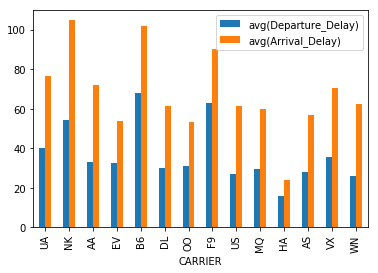

In [25]:
pandas_df = delay.toPandas()
pandas_df.plot(x="CARRIER", y=["avg(Departure_Delay)", "avg(Arrival_Delay)"], kind="bar")